In [1]:
import pandas as pd



In [2]:
#load Amfar opioid and HIV data, add county code
opiod_df = pd.read_table('data/amfAR/countydata.tsv',header=0)
opiod_df['county_code'] = opiod_df.STATEFP*1000 + opiod_df.COUNTYFP # build a county code column
opiod_df['county_code'] = opiod_df.county_code.astype(int)

In [3]:
opiod_df.head()


,STATEFP,COUNTYFP,YEAR,INDICATOR,VALUE,COUNTY,STATE,STATEABBREVIATION,county_code
0,1,1,2017,bup_phys,2.0,Autauga County,Alabama,AL,1001
1,1,3,2017,bup_phys,13.0,Baldwin County,Alabama,AL,1003
2,1,5,2017,bup_phys,0.0,Barbour County,Alabama,AL,1005
3,1,7,2017,bup_phys,0.0,Bibb County,Alabama,AL,1007
4,1,9,2017,bup_phys,1.0,Blount County,Alabama,AL,1009


In [4]:
#make changes to the amfar dataframe
#convert from long to wide format
index_lst = ['county_code', 'COUNTY', 'STATEABBREVIATION', 'YEAR']
col_lst = ['INDICATOR']
opiod_df_wide = opiod_df.pivot_table(values='VALUE', index=index_lst, columns=col_lst).reset_index()

In [5]:
# Focus on just the HIV related data, from 2008 onward
opiod_df_wide = opiod_df_wide[opiod_df_wide['YEAR'] >= 2008] # subset for years that have hiv data
cols_to_drop = ['CDC_consult', 'vulnerable_rank']
#, 'num_SSPs', 'bup_phys', 'drugdep', 'pctunmetneed', 'nonmedpain']
opiod_df_wide.drop(cols_to_drop, axis=1, inplace=True) # drop unnecessary columns

In [6]:
pd.get_option("display.max_columns")


20

In [7]:
pd.set_option("display.max_columns", 100)


In [8]:
fill_nan_cols = ['HIVdiagnoses', 'HIVincidence', 'HIVprevalence',
                 'PLHIV', 'drugdeathrate', 'drugdeaths']
opiod_df_wide[fill_nan_cols] = opiod_df_wide[fill_nan_cols].fillna(0) #fill NaNs for suppressed data with zeroes

In [9]:
opiod_df_15 = opiod_df_wide[opiod_df_wide['YEAR'] == 2015]


In [10]:
pd.options.mode.chained_assignment = None  # default='warn', get rid of annoying warning associated with dropping below
# drop columns having no 2015 data, will be extraploated from following years later
opiod_df_15.drop(['num_SSPs', 'bup_phys', 'drugdep', 'pctunmetneed', 'nonmedpain'], axis=1, inplace=True)

In [11]:
# get esimates for num_SSPs, bug_phys, drug_dep, pctunmetneed, and nonmedpain from following years

#subset opioid related data from one year only
#number of needle exchange programs (num_SSPs)
opiod_df_wide_17 = opiod_df_wide[opiod_df_wide['YEAR'] == 2017]
df_num_SSP = opiod_df_wide_17[['num_SSPs', 'county_code']]

#number of doctors licensed to rx Buprenorphine (bup_phys)
df_bup_phys = opiod_df_wide_17[['bup_phys', 'county_code']]

#percent with drug dependency (drug_dep)
opiod_df_wide_16 = opiod_df_wide[opiod_df_wide['YEAR'] == 2016]
df_drugdep = opiod_df_wide_16[['drugdep', 'county_code']]

#percent unmet drug treatment need (pctunmetneed)
df_pctunmetneed = opiod_df_wide_16[['pctunmetneed', 'county_code']]

#percent taken pain meds for nonmedical use (nonmedpain)
df_nonmedpain = opiod_df_wide_16[['nonmedpain', 'county_code']]

In [12]:
# merge these values back into 2015 dataframe
#merge opioid related data back to the 2015 dataframe
opiod_df_15 = opiod_df_15.merge(df_num_SSP, on='county_code')
opiod_df_15 = opiod_df_15.merge(df_bup_phys, on='county_code')
opiod_df_15 = opiod_df_15.merge(df_drugdep, on='county_code')
opiod_df_15 = opiod_df_15.merge(df_pctunmetneed, on='county_code')
opiod_df_15 = opiod_df_15.merge(df_nonmedpain, on='county_code')

In [13]:
#load Men who have sex with men (MSM) estimate data
msm_df = pd.read_csv("data/CAMP/US_MSM_Estimates_Data_2013.csv")    #load the data
msm_df['county_code'] = msm_df.STATEFP*1000 + msm_df.COUNTYFP  # build a county code column
msm_df['county_code'] = msm_df.county_code.astype(int)
msm_df['%msm12month'] = 100 * (msm_df.MSM12MTH / msm_df.ADULTMEN) # build a %MSM within last 12 months column
msm_df['%msm5yr'] = 100 * (msm_df.MSM5YEAR / msm_df.ADULTMEN)     # build a %MSM within last 5years column

In [14]:
cols_to_drop = ['REGCODE', 'DIVCODE', 'STATEFP', 'COUNTYFP', 'CSACODE', 
                'CBSACODE','METDCODE', 'METMICSA', 'CENTOUTL']
msm_df.drop(cols_to_drop, axis=1, inplace=True) #drop all unneeded columns
msm_df.head()

,ADULTMEN,MSM12MTH,MSM5YEAR,county_code,%msm12month,%msm5yr
0,19410,333,514,1001,1.715611,2.648120
1,69724,925,1429,1003,1.326659,2.049509
2,11567,82,127,1005,0.708913,1.097951
3,9508,119,184,1007,1.251578,1.935212
4,21368,601,928,1009,2.812617,4.342943


In [15]:
#unemplyment data
df_employment = pd.read_csv("data/ACS_14_5YR_employment/ACS_14_5YR_S2301_with_ann.csv", 
                            encoding = "ISO-8859-1", skiprows=1)
df_employment = df_employment[['Id2', 'Unemployment rate; Estimate; Population 16 years and over']]
df_employment.columns = ['county_code', 'unemployment_rate']
df_employment.head()

,county_code,unemployment_rate
0,1001,8.5
1,1003,8.6
2,1005,14.2
3,1007,10.9
4,1009,9.3


In [16]:
#poverty data
df_poverty = pd.read_csv("data/ACS_14_5YR_poverty/ACS_14_5YR_S1701_with_ann.csv", 
                         encoding = "ISO-8859-1", skiprows=1)
df_poverty = df_poverty[['Id2', 'Percent below poverty level; Estimate; Population for whom poverty status is determined']]
df_poverty.columns = ['county_code', 'poverty_rate']
df_poverty.head()

/Users/andrealittle/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (13,14,19,20,193,194,265,266) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,county_code,poverty_rate
0,1001,12.8
1,1003,13.8
2,1005,24.1
3,1007,17.0
4,1009,17.3


In [17]:
#income data
df_income = pd.read_csv("data/ACS_14_5YR_income/ACS_14_5YR_S1901_with_ann.csv", 
                        encoding = "ISO-8859-1", skiprows=1)
df_income = df_income[['Id2', 'Households; Estimate; Total']]
df_income.columns = ['county_code', 'household_income']
df_income.head()

,county_code,household_income
0,1001,20304
1,1003,73058
2,1005,9145
3,1007,7078
4,1009,20934


In [29]:
#Insurance data
df_insurance = pd.read_csv("data/ACS_14_5YR_health_insur_coverage/ACS_14_5YR_S2701_with_ann.csv", 
                        encoding = "ISO-8859-1", skiprows=1)
df_insurance = df_insurance[['Id2', 'Total; Estimate; SEX - Male', 'Number Uninsured; Estimate; SEX - Male']]
df_insurance.columns = ['county_code', 'Insured Males', 'Uninsured Males']
df_insurance.head()

#merge asfAR hiv/opioid data with CAMP MSM data
df_main = opiod_df_15.merge(msm_df, on='county_code')

#merge in ACS data
df_main = df_main.merge(df_employment, on='county_code')
df_main = df_main.merge(df_poverty, on='county_code')
df_main = df_main.merge(df_income, on='county_code')
df_main = df_main.merge(df_insurance, on='county_code')

/Users/andrealittle/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (47,48,117,118,137,138,147,148,167,168,187,188,207,208,297,298,337,338,437,438) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_main.info()

/Users/andrealittle/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (47,48,117,118,137,138,147,148,167,168,187,188,207,208,297,298,337,338,437,438) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,county_code,Insured Males,Uninsured Males
0,1001,26153,2900
1,1003,91434,15173
2,1005,11774,2038
3,1007,10799,1398
4,1009,28349,3838


In [21]:
# HIV incidences - new infections per 100,000 
# (regardless of if they have been diagnosed)
import matplotlib.pyplot as plt
# prevalence - existing number of cases
# diagnoses - new diagnoses 
%matplotlib inline 

In [30]:
print(df_main['HIVincidence'].max())
# idx max - 767
df_main.drop(767, axis = 0, inplace=True)

# fig, ax = plt.subplots(3, 3)
# fig.tight_layout()
# cols = ['AMAT_fac', 'MH_fac', 'HIVdiagnoses', 'HIVprevalence', 'Med_AMAT_fac',
#    'Med_MH_fac', 'Med_SA_fac', 'Med_SMAT_fac']
# for i in range(3):
#     for j in range(3):
#         ax[i, j].scatter(df_main["HIVincidence"], df_main[cols[i+j]])
#         ax[i, j].set_title(cols[i+j])
# plt.show()
# ax[0, 0].scatter(df_main["HIVincidence"], df_main["MH_fac"])
# ax[0, 0].set_title("MH_fac")
# plt.show()

# df_main['YEAR'].unique()


771.4


Index(['Med_TMAT_fac', 'PLHIV', 'Population', 'SA_fac', 'SMAT_fac', 'TMAT_fac',
       'drugdeathrate', 'drugdeathrate_est', 'drugdeaths'],
      dtype='object')


/Users/andrealittle/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


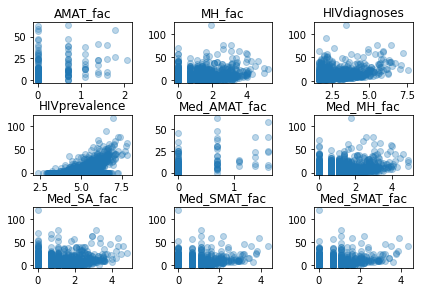

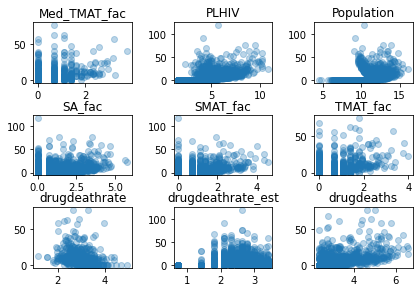

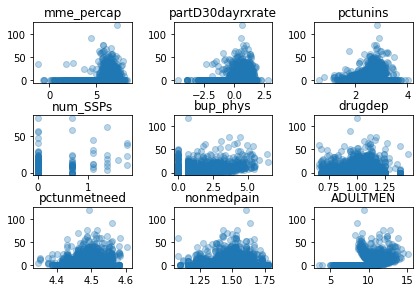

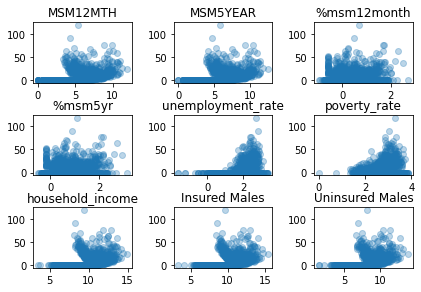

In [50]:
# get rid of -YEAR column, all 2015
# county, stateabbrev wont see linear relation
# drop Med_AMAT_fac possibly, 
# starting at 13 - 21
import numpy as np
print(df_main.columns[13:22])
def incidence_plt(cols):
    fig, ax = plt.subplots(3, 3)
    fig.tight_layout()
    z = 0
    for i in range(3):
        for j in range(3):
            ax[i, j].scatter(np.log(df_main[cols[z]]), df_main["HIVincidence"], alpha = 0.3)
            ax[i, j].set_title(cols[z])
            z += 1
    plt.show()
incidence_plt(['AMAT_fac', 'MH_fac', 'HIVdiagnoses', 'HIVprevalence', 'Med_AMAT_fac',
   'Med_MH_fac', 'Med_SA_fac', 'Med_SMAT_fac', 'Med_SMAT_fac'])
incidence_plt(df_main.columns[13:22])
incidence_plt(df_main.columns[22:31])
incidence_plt(df_main.columns[31:])


In [34]:
# remove indicators: num_SSPS, Med_AMAT_fac, AMAT_fac, Med_MH_fac, 
# Med_SMAAT_fac, 
#
# county, stateabbrev, 
X = df_main[[
    'AMAT_fac', 
    'HIVprevalence', 
    'MH_fac', 
    'Med_AMAT_fac',
    'Med_SA_fac',
    'Med_SMAT_fac',
    'PLHIV',
    'Population',
    'SA_fac',
    'SMAT_fac',
    'drugdeathrate',
    'drugdeaths',
    'MSM12MTH',
    'MSM5YEAR',
    'unemployment_rate',
    'poverty_rate',
    'household_income'
]]
y = df_main['HIVincidence']

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y)
def create_model(X,y):
    model = LinearRegression()
    model.fit(X,y)
    return model
def plot_residual(X_test, y_test, model, label='Residual Plot'):
    y_pred = model.predict(X_test)
    residuals = y_pred - y_test
    plt.scatter(y_pred, residuals, alpha = .35, label=label)
    plt.legend()
    plt.show()
    return residuals

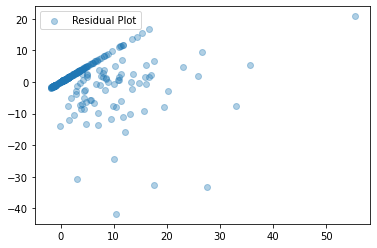

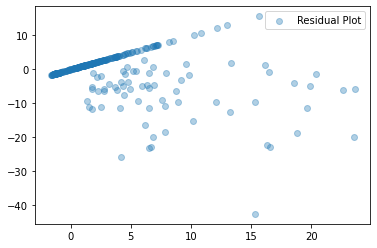

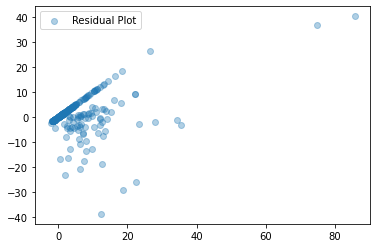

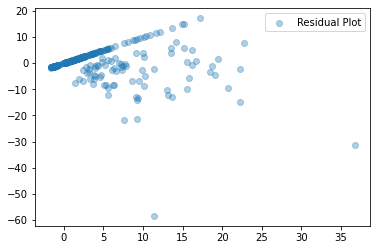

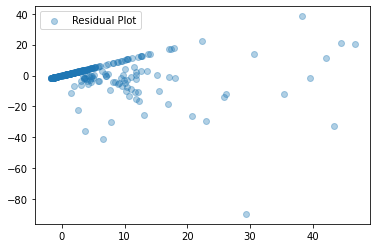

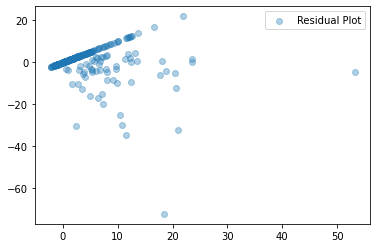

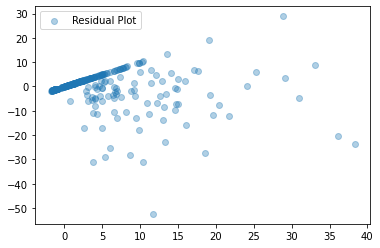

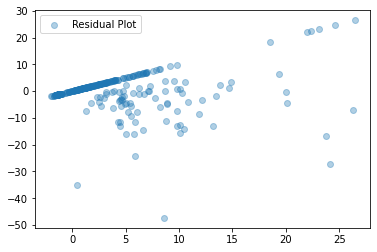

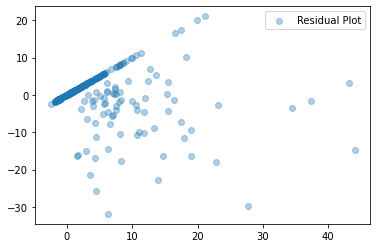

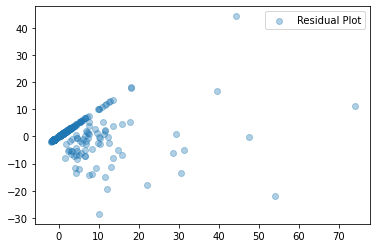

45.38238000396442


In [52]:
from sklearn.model_selection import KFold
from statistics import mean
def get_crossvalidated_error(n_folds, X, y):
    kf = KFold(n_splits=n_folds, shuffle=True) 
    list_mse = []
    for train, test in kf.split(X):
        X_train = X.values[train]
        X_test = X.values[test]
        y_train = y.values[train]
        y_test = y.values[test]
        model = create_model(X_train, y_train)
        yhat = model.predict(X_test)
        err = mean_squared_error(yhat, y_test)
        list_mse.append(err)
        plot_residual(X_test, y_test, model, label='Residual Plot')
    print(mean(list_mse))

get_crossvalidated_error(10, X, y)
        
